In [1]:
cd Downloads/archive

C:\Users\Administrator\Downloads\archive


In [2]:
# Load and explore the EPL player stats dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('epl_player_stats_24_25.csv', encoding='utf-8-sig')

print("Dataset shape:", df.shape)
print("\
Column names:")
print(df.columns.tolist())
print("\
First few rows:")
print(df.head())

Dataset shape: (562, 57)
Column names:
['Player Name', 'Club', 'Nationality', 'Position', 'Appearances', 'Minutes', 'Goals', 'Assists', 'Shots', 'Shots On Target', 'Conversion %', 'Big Chances Missed', 'Hit Woodwork', 'Offsides', 'Touches', 'Passes', 'Successful Passes', 'Passes%', 'Crosses', 'Successful Crosses', 'Crosses %', 'fThird Passes', 'Successful fThird Passes', 'fThird Passes %', 'Through Balls', 'Carries', 'Progressive Carries', 'Carries Ended with Goal', 'Carries Ended with Assist', 'Carries Ended with Shot', 'Carries Ended with Chance', 'Possession Won', 'Dispossessed', 'Clean Sheets', 'Clearances', 'Interceptions', 'Blocks', 'Tackles', 'Ground Duels', 'gDuels Won', 'gDuels %', 'Aerial Duels', 'aDuels Won', 'aDuels %', 'Goals Conceded', 'xGoT Conceded', 'Own Goals', 'Fouls', 'Yellow Cards', 'Red Cards', 'Saves', 'Saves %', 'Penalties Saved', 'Clearances Off Line', 'Punches', 'High Claims', 'Goals Prevented']
First few rows:
     Player Name     Club Nationality Position  A

In [3]:
# Data exploration and cleaning
print("Data types:")
print(df.dtypes)
print("\
Missing values:")
print(df.isnull().sum().sum())
print("\
Basic statistics:")
print(df.describe())

Data types:
Player Name                   object
Club                          object
Nationality                   object
Position                      object
Appearances                    int64
Minutes                        int64
Goals                          int64
Assists                        int64
Shots                          int64
Shots On Target                int64
Conversion %                  object
Big Chances Missed             int64
Hit Woodwork                   int64
Offsides                       int64
Touches                        int64
Passes                         int64
Successful Passes              int64
Passes%                       object
Crosses                        int64
Successful Crosses             int64
Crosses %                     object
fThird Passes                  int64
Successful fThird Passes       int64
fThird Passes %               object
Through Balls                  int64
Carries                        int64
Progressive Carries       

In [4]:
# Clean percentage columns and convert to numeric
percentage_cols = ['Conversion %', 'Passes%', 'Crosses %', 'fThird Passes %', 'gDuels %', 'aDuels %', 'Saves %']

for col in percentage_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('%', '').replace('nan', '0')
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Check for any remaining non-numeric columns that should be numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns count:", len(numeric_cols))

# Handle categorical variables
categorical_cols = ['Club', 'Nationality', 'Position']
print("Categorical columns:", categorical_cols)

# Check unique values in Position
print("\
Unique positions:")
print(df['Position'].value_counts())

# Check data distribution for key metrics
print("\
Key metrics distribution:")
key_metrics = ['Goals', 'Assists', 'Minutes', 'Appearances']
for metric in key_metrics:
    print(f"{metric}: min={df[metric].min()}, max={df[metric].max()}, mean={df[metric].mean():.2f}")

Numeric columns count: 53
Categorical columns: ['Club', 'Nationality', 'Position']
Unique positions:
Position
MID    229
DEF    202
FWD     86
GKP     45
Name: count, dtype: int64
Key metrics distribution:
Goals: min=0, max=29, mean=1.71
Assists: min=0, max=18, mean=1.15
Minutes: min=1, max=3420, mean=1336.21
Appearances: min=1, max=38, mean=20.58


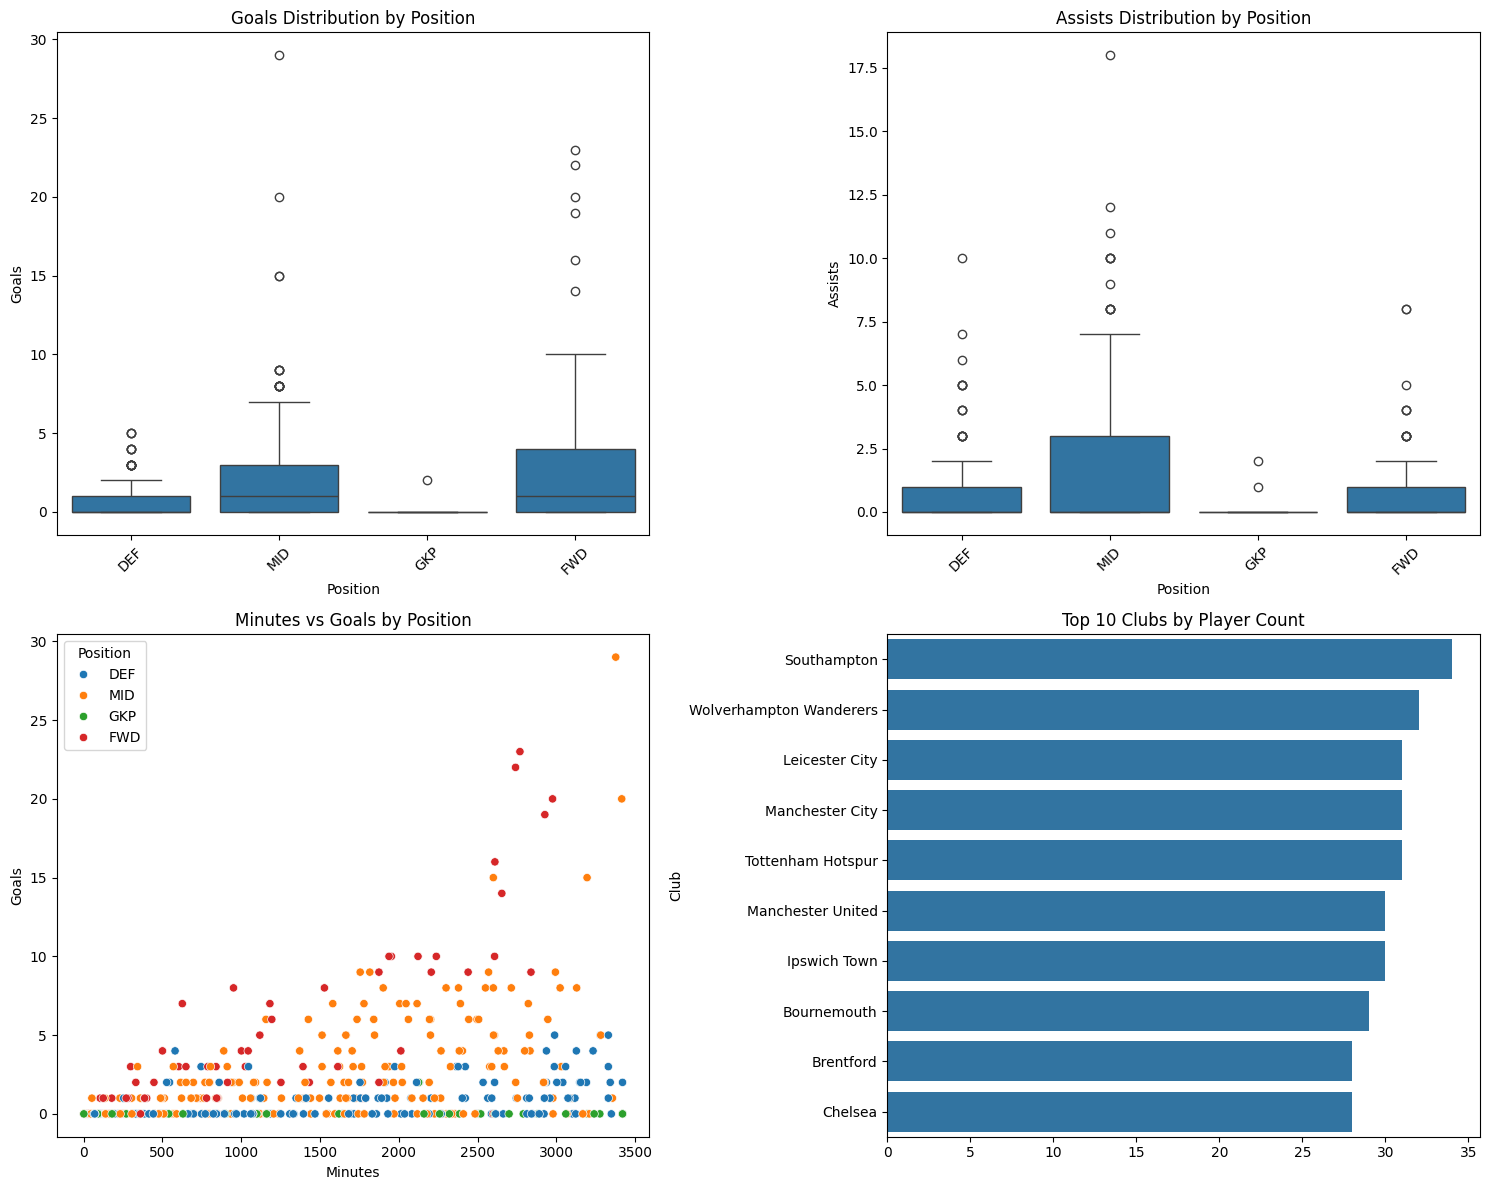

Data exploration visualizations completed


In [5]:
# Create visualizations for data exploration
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Goals distribution by position
sns.boxplot(data=df, x='Position', y='Goals', ax=axes[0,0])
axes[0,0].set_title('Goals Distribution by Position')
axes[0,0].tick_params(axis='x', rotation=45)

# Assists distribution by position
sns.boxplot(data=df, x='Position', y='Assists', ax=axes[0,1])
axes[0,1].set_title('Assists Distribution by Position')
axes[0,1].tick_params(axis='x', rotation=45)

# Minutes vs Goals scatter plot
sns.scatterplot(data=df, x='Minutes', y='Goals', hue='Position', ax=axes[1,0])
axes[1,0].set_title('Minutes vs Goals by Position')

# Top clubs by number of players
top_clubs = df['Club'].value_counts().head(10)
sns.barplot(x=top_clubs.values, y=top_clubs.index, ax=axes[1,1])
axes[1,1].set_title('Top 10 Clubs by Player Count')

plt.tight_layout()
plt.show()

print("Data exploration visualizations completed")

In [6]:
# Install required packages for Bayesian optimization
%pip install scikit-optimize xgboost lightgbm

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 738.9 kB/s eta 0:03:23
   ---------------------------------------- 0.5/150.0 MB 738.9 kB/s eta 0:03:23
   ---------------------------------------- 0.8/150.0 MB 692.2 kB/s eta 0:03:36
   ---------------------------------------- 0.8/150.0 MB 692.2 kB/s eta 0:03:36
   ---------------------------------------- 1.0/150.0 MB 650.6 kB/s eta 0:03:49
   ---------------------------------------- 1.0/150.0 MB 650.6 kB/s eta 0:03:49
   ---------------------------------------- 1.3/150.0 MB 640.4 kB/s eta 0:03:53
   ---------------------------------------- 1.3/150.0 MB 640.4 kB/s eta 0:03:53
   ---------------------------------------- 1.6/150.0 MB 647.5 kB/s eta 0:03

In [7]:
# Prepare data for modeling - create multiple prediction targets
import xgboost as xgb
import lightgbm as lgb
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
import pandas as pd
import numpy as np

# Create feature matrix and target variables
# First, encode categorical variables
le_position = LabelEncoder()
le_club = LabelEncoder()
le_nationality = LabelEncoder()

df_model = df.copy()
df_model['Position_encoded'] = le_position.fit_transform(df_model['Position'])
df_model['Club_encoded'] = le_club.fit_transform(df_model['Club'])
df_model['Nationality_encoded'] = le_nationality.fit_transform(df_model['Nationality'])

# Select features for modeling (excluding target variables and identifiers)
feature_cols = [col for col in df_model.columns if col not in ['Player Name', 'Club', 'Nationality', 'Position', 'Goals', 'Assists', 'Minutes', 'xGoT Conceded', 'Goals Prevented']]

# Define multiple prediction targets
targets = {
    'Goals': 'Goals',
    'Assists': 'Assists', 
    'Minutes': 'Minutes',
    'xGoT_Conceded': 'xGoT Conceded',
    'Goals_Prevented': 'Goals Prevented'
}

print("Feature columns selected:", len(feature_cols))
print("Targets defined:", list(targets.keys()))
print("Sample features:", feature_cols[:10])

Feature columns selected: 51
Targets defined: ['Goals', 'Assists', 'Minutes', 'xGoT_Conceded', 'Goals_Prevented']
Sample features: ['Appearances', 'Shots', 'Shots On Target', 'Conversion %', 'Big Chances Missed', 'Hit Woodwork', 'Offsides', 'Touches', 'Passes', 'Successful Passes']


In [8]:
# Define features and targets for modeling
# Select numeric features (excluding target variables and identifiers)
numeric_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['Player Name', 'Goals', 'Assists', 'Minutes', 'xGoT Conceded', 'Goals Prevented']
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Add encoded categorical features
feature_cols.extend(['Position_encoded', 'Club_encoded', 'Nationality_encoded'])

# Define prediction targets
targets = {
    'Goals': 'Goals',
    'Assists': 'Assists', 
    'Minutes': 'Minutes'
}

print("Features selected:", len(feature_cols))
print("Sample features:", feature_cols[:10])
print("Targets:", list(targets.keys()))

# Check feature matrix shape
X = df_model[feature_cols]
print("Feature matrix shape:", X.shape)
print("Feature matrix info:")
print("Non-null values per feature (first 10):")
for i, col in enumerate(feature_cols[:10]):
    print(f"{col}: {X[col].count()}/{len(X)}")

Features selected: 54
Sample features: ['Appearances', 'Shots', 'Shots On Target', 'Conversion %', 'Big Chances Missed', 'Hit Woodwork', 'Offsides', 'Touches', 'Passes', 'Successful Passes']
Targets: ['Goals', 'Assists', 'Minutes']
Feature matrix shape: (562, 54)
Feature matrix info:
Non-null values per feature (first 10):
Appearances: 562/562
Shots: 562/562
Shots On Target: 562/562
Conversion %: 562/562
Big Chances Missed: 562/562
Hit Woodwork: 562/562
Offsides: 562/562
Touches: 562/562
Passes: 562/562
Successful Passes: 562/562


In [9]:
# Build and evaluate multiple models for each target
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Ridge Regression': Ridge(random_state=42),
    'Elastic Net': ElasticNet(random_state=42),
    'SVR': SVR()
}

# Define parameter grids for optimization
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'Ridge Regression': {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    },
    'Elastic Net': {
        'alpha': [0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.5, 0.9]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    }
}

# Results storage
results = {}
best_models = {}

print("Starting model training and optimization...")
print("This may take a few minutes...")

# Train models for each target
for target_name, target_col in targets.items():
    print(f"\
Training models for {target_name}...")
    
    X = df_model[feature_cols]
    y = df_model[target_col]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results[target_name] = {}
    
    for model_name, model in models.items():
        start_time = time.time()
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            model, 
            param_grids[model_name], 
            cv=5, 
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        
        # Fit model
        if model_name in ['Ridge Regression', 'Elastic Net', 'SVR']:
            grid_search.fit(X_train_scaled, y_train)
            y_pred = grid_search.predict(X_test_scaled)
        else:
            grid_search.fit(X_train, y_train)
            y_pred = grid_search.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[target_name][model_name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Best_Params': grid_search.best_params_,
            'CV_Score': -grid_search.best_score_,
            'Training_Time': time.time() - start_time
        }
        
        # Store best model
        if target_name not in best_models:
            best_models[target_name] = {}
        best_models[target_name][model_name] = {
            'model': grid_search.best_estimator_,
            'scaler': scaler if model_name in ['Ridge Regression', 'Elastic Net', 'SVR'] else None
        }
        
        print(f"  {model_name}: RMSE={rmse:.3f}, R2={r2:.3f}, Time={time.time()-start_time:.1f}s")

print("\
Model training completed!")

Starting model training and optimization...
This may take a few minutes...
Training models for Goals...
  Random Forest: RMSE=2.163, R2=0.502, Time=46.9s
  Gradient Boosting: RMSE=2.212, R2=0.479, Time=20.2s
  Ridge Regression: RMSE=1.909, R2=0.612, Time=0.1s
  Elastic Net: RMSE=1.852, R2=0.635, Time=0.1s
  SVR: RMSE=1.820, R2=0.647, Time=4.0s
Training models for Assists...
  Random Forest: RMSE=1.296, R2=0.519, Time=43.9s
  Gradient Boosting: RMSE=1.324, R2=0.498, Time=18.2s
  Ridge Regression: RMSE=1.283, R2=0.529, Time=0.0s
  Elastic Net: RMSE=1.272, R2=0.537, Time=0.1s
  SVR: RMSE=1.341, R2=0.485, Time=3.6s
Training models for Minutes...
  Random Forest: RMSE=190.266, R2=0.962, Time=46.8s
  Gradient Boosting: RMSE=170.169, R2=0.970, Time=19.4s
  Ridge Regression: RMSE=182.130, R2=0.965, Time=0.0s
  Elastic Net: RMSE=185.606, R2=0.964, Time=0.1s
  SVR: RMSE=186.010, R2=0.964, Time=0.3s
Model training completed!


In [15]:
df_model[feature_cols].columns

Index(['Appearances', 'Shots', 'Shots On Target', 'Conversion %',
       'Big Chances Missed', 'Hit Woodwork', 'Offsides', 'Touches', 'Passes',
       'Successful Passes', 'Passes%', 'Crosses', 'Successful Crosses',
       'Crosses %', 'fThird Passes', 'Successful fThird Passes',
       'fThird Passes %', 'Through Balls', 'Carries', 'Progressive Carries',
       'Carries Ended with Goal', 'Carries Ended with Assist',
       'Carries Ended with Shot', 'Carries Ended with Chance',
       'Possession Won', 'Dispossessed', 'Clean Sheets', 'Clearances',
       'Interceptions', 'Blocks', 'Tackles', 'Ground Duels', 'gDuels Won',
       'gDuels %', 'Aerial Duels', 'aDuels Won', 'aDuels %', 'Goals Conceded',
       'Own Goals', 'Fouls', 'Yellow Cards', 'Red Cards', 'Saves', 'Saves %',
       'Penalties Saved', 'Clearances Off Line', 'Punches', 'High Claims',
       'Position_encoded', 'Club_encoded', 'Nationality_encoded',
       'Position_encoded', 'Club_encoded', 'Nationality_encoded'],
     

In [22]:
np.array(X.iloc[0]).reshape(1,-1)

array([[  17,    9,   12,   13,    0,    0,    1,  833, 1678, 1493,   89,
          51,   10,   20,  714,  592,   83,    4,  583,  296,    0,    0,
           5,   17,  107,    6,    5,   38,   23,    6,   20,  231,  116,
          50,   16,    5,   31,    0,    0,   10,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   20,    0,    0,   20]])

In [24]:
grid_search.predict(np.array(X.iloc[0]).reshape(1,-1)).item()

311183.8981777092

In [27]:
import joblib

In [28]:
joblib.dump(grid_search, "model.pkl")

['model.pkl']

In [30]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 4675-1D81

 Directory of C:\Users\Administrator\Downloads\archive

06/26/2025  02:08 PM    <DIR>          .
06/26/2025  02:08 PM    <DIR>          ..
06/14/2025  02:46 AM           100,266 epl_player_stats_24_25.csv
06/26/2025  02:08 PM           207,727 model.pkl
               2 File(s)        307,993 bytes
               2 Dir(s)  124,525,182,976 bytes free


In [32]:
X.columns.tolist()

['Appearances',
 'Shots',
 'Shots On Target',
 'Conversion %',
 'Big Chances Missed',
 'Hit Woodwork',
 'Offsides',
 'Touches',
 'Passes',
 'Successful Passes',
 'Passes%',
 'Crosses',
 'Successful Crosses',
 'Crosses %',
 'fThird Passes',
 'Successful fThird Passes',
 'fThird Passes %',
 'Through Balls',
 'Carries',
 'Progressive Carries',
 'Carries Ended with Goal',
 'Carries Ended with Assist',
 'Carries Ended with Shot',
 'Carries Ended with Chance',
 'Possession Won',
 'Dispossessed',
 'Clean Sheets',
 'Clearances',
 'Interceptions',
 'Blocks',
 'Tackles',
 'Ground Duels',
 'gDuels Won',
 'gDuels %',
 'Aerial Duels',
 'aDuels Won',
 'aDuels %',
 'Goals Conceded',
 'Own Goals',
 'Fouls',
 'Yellow Cards',
 'Red Cards',
 'Saves',
 'Saves %',
 'Penalties Saved',
 'Clearances Off Line',
 'Punches',
 'High Claims',
 'Position_encoded',
 'Club_encoded',
 'Nationality_encoded',
 'Position_encoded',
 'Club_encoded',
 'Nationality_encoded']